# 6 The Haunted DAG & The Causal Terror

In [1]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import pandas as pd
from causalgraphicalmodels import CausalGraphicalModel

import jax.numpy as jnp
from jax import lax, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu")

/Users/koenrademaker/miniconda3/envs/NUMPYRO/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 6.1
with numpyro.handlers.seed(rng_seed=1914):
    N = 200
    p = 0.1
    # uncorrelated newsworthiness and trustworthiness
    nw = numpyro.sample('nw', dist.Normal().expand([N]))
    tw = numpyro.sample('tw', dist.Normal().expand([N]))
    # top 10% of combined scores
    s = nw + tw
    q = jnp.quantile(s, 1 - p)
    selected = jnp.where(s >= q, True, False)
jnp.corrcoef(jnp.stack([tw[selected], nw[selected]], 0))[0,1]

I0000 00:00:1704887575.864758       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Array(-0.6453357, dtype=float32)

## 6.1 Multicollinearity

### 6.1.1 Multicollinear legs

"Surely height is positively associated with leg length, or at least the simulation will assume it is. Nevertheless, once you put both leg lengths into the model, something vexing will happen. The code below will simulate the heights and leg lengths of 100 individuals"

In [23]:
# 6.2
N = 100
with numpyro.handlers.seed(rng_seed=909):
    # simulate total height
    height = numpyro.sample('height', dist.Normal(10,2).expand([N]))
    # simulate leg as proportion of height
    leg_prop = numpyro.sample('prop', dist.Uniform(0.4,0.5).expand([N]))
    # simulate left leg => proportion + error
    leg_left = leg_prop * height + numpyro.sample(
        'left_error', dist.Normal(0, 0.02).expand([N])
    )
    # simulate right leg => proportion + error
    leg_right = leg_prop * height + numpyro.sample(
        'right_error', dist.Normal(0, 0.02).expand([N])
    )
    # combine data
    d = pd.DataFrame({'height':height, 'leg_left':leg_left, 'leg_right':leg_right})

Assumptions: We will predict height with both predictors (leg left/right) and expect average individual legs to represent 45% of height. With the average simulated height, this means we expect the beta coeff. for a leg's association with height to be around $10/4.5 \approx 2.2$.

In [24]:
# 6.3
# Example with vague priors
def model(leg_left, leg_right, height):
    a = numpyro.sample('a', dist.Normal(10, 100))
    bl = numpyro.sample('bl', dist.Normal(2,10))
    br = numpyro.sample('br', dist.Normal(2,10))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bl*leg_left + br*leg_right
    numpyro.sample('height', dist.Normal(mu,sigma), obs=height)

m6_1 = AutoLaplaceApproximation(model)
svi = SVI(model,
          m6_1,
          optim.Adam(0.1),
          Trace_ELBO(),
          leg_left=d.leg_left.values,
          leg_right=d.leg_right.values,
          height=d.height.values,
         )
svi_result = svi.run(random.PRNGKey(0), 2000)
p6_1 = svi_result.params
post = m6_1.sample_posterior(random.PRNGKey(1), p6_1, (1000,))
print_summary(post, 0.89, False)

100%|█| 2000/2000 [00:00<00:00, 9623.99it/s, init loss: 62894.3711, avg. loss [1



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.81      0.34      0.80      0.27      1.31   1049.96      1.00
        bl      2.61      2.27      2.63     -1.05      6.25    813.18      1.00
        br     -0.59      2.27     -0.60     -4.40      2.95    805.73      1.00
     sigma      0.67      0.05      0.67      0.60      0.74    968.53      1.00



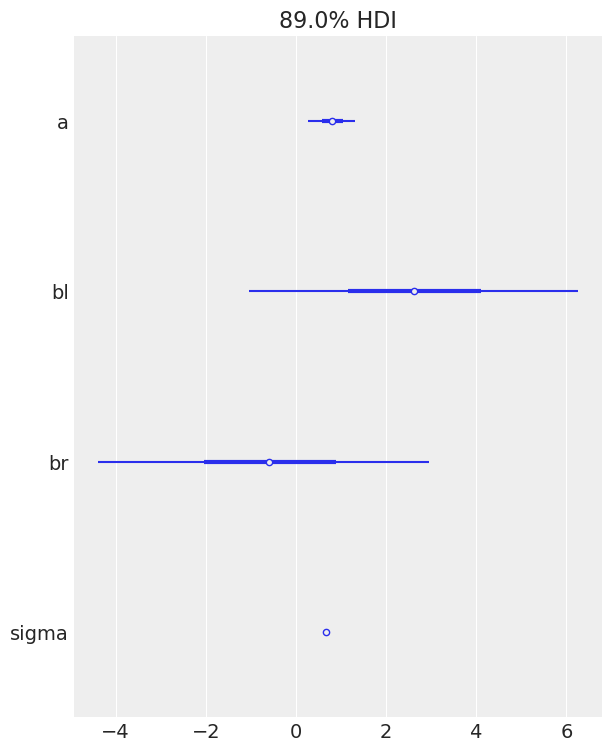

In [25]:
# 6.4
az.plot_forest(post, hdi_prob=0.89)
plt.show()

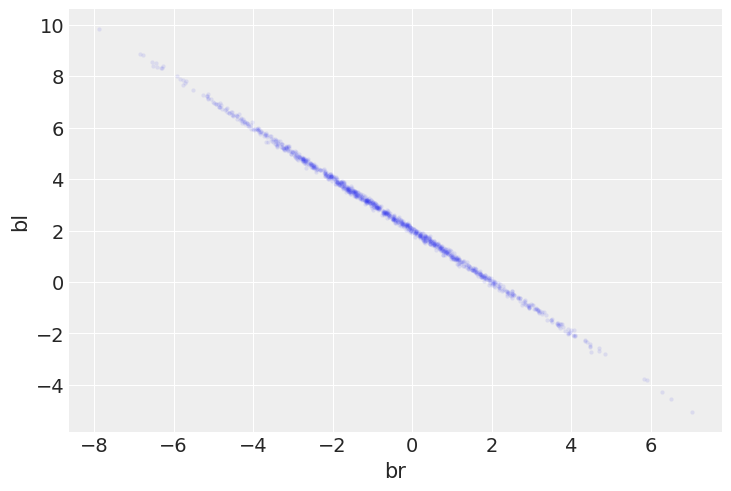

In [26]:
# 6.5
# Bivariate posterior distribution of bl and br
post = m6_1.sample_posterior(random.PRNGKey(1), p6_1, (1000,))
az.plot_pair(post, var_names=['br', 'bl'], scatter_kwargs={'alpha': 0.1})
plt.show()

Consider this phenomenon as:

$y_i \sim \mathcal{N}(\mu_i, \sigma)$

$\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i$

$\mu_i = \alpha + (\beta_1 + \beta_2)x_i$

Where the posterior will then only use combinations of $beta_1$ and $beta_2$ that make their sum close to the actual association of $x$ with $y$, which we see as $bl \approx 2.6 \rightarrow br \approx 0$ in the posterior output.

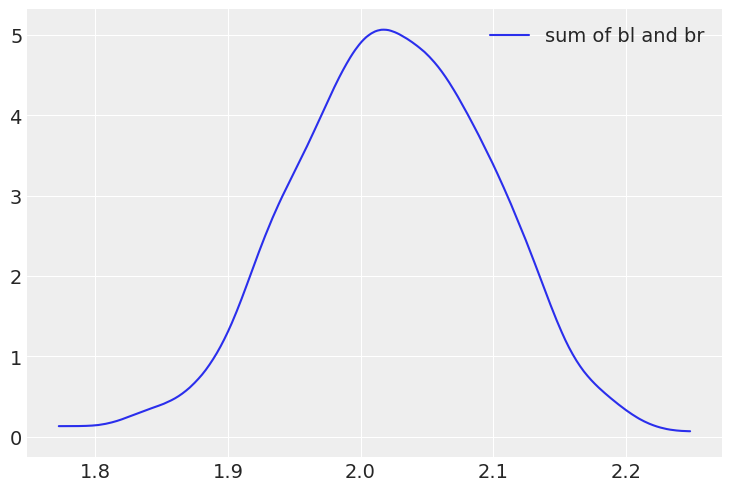

In [28]:
# 6.6
# Compute posterior distribution of sum of bl and br
sum_blbr = post['bl'] + post['br']
az.plot_kde(sum_blbr, label='sum of bl and br')
plt.show()

In [30]:
# 6.7
# fit a regression with only one leg length variable
# 6.3
# Example with vague priors
def model(leg_left, height):
    a = numpyro.sample('a', dist.Normal(10, 100))
    bl = numpyro.sample('bl', dist.Normal(2,10))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bl * leg_left
    numpyro.sample('height', dist.Normal(mu,sigma), obs=height)

m6_2 = AutoLaplaceApproximation(model)
svi = SVI(model,
          m6_2,
          optim.Adam(1),
          Trace_ELBO(),
          leg_left=d.leg_left.values,
          height=d.height.values,
         )

svi_result = svi.run(random.PRNGKey(0), 1000)
p6_2 = svi_result.params
post = m6_2.sample_posterior(random.PRNGKey(1), p6_2, (1000,))
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 6592.00it/s, init loss: 2486.2405, avg. loss [95



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.83      0.35      0.84      0.25      1.35    931.50      1.00
        bl      2.02      0.08      2.02      1.91      2.15    940.42      1.00
     sigma      0.67      0.05      0.67      0.60      0.75    949.09      1.00



In [31]:
jnp.mean(sum_blbr)

Array(2.0230172, dtype=float32)

Now, beta coefficient $bl$ is almost identical to the mean value of _sum_blbr_.

### 6.1.2 Multicollinear milk

Extension to a causally inspired example dataset.

In [32]:
# 6.8
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["F"] = d["perc.fat"].pipe(lambda x: (x - x.mean()) / x.std())
d["L"] = d["perc.lactose"].pipe(lambda x: (x - x.mean()) / x.std())

Start by modelling _kcal.per.g_ as a function of _perc.fat_ and _perc.lac_, but in two bivariate regressions.

In [33]:
# 6.9

#-------------------------
# kcal.per.g regressed on perc.fat
def model(F, K):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bF = numpyro.sample('bF', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bF * F
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)
#------------------------#
m6_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_3, optim.Adam(1), Trace_ELBO(), F=d.F.values, K=d.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p6_3 = svi_result.params


#-------------------------
# kcal.per.g regressed on perc.lactose
def model(L, K):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bL = numpyro.sample('bL', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bL * L
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)
#------------------------#
m6_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m6_4, optim.Adam(1), Trace_ELBO(), L=d.L.values, K=d.K.values)
svi_result = svi.run(random.PRNGKey(0), 1000)
p6_4 = svi_result.params

100%|█| 1000/1000 [00:00<00:00, 7158.41it/s, init loss: 198.3563, avg. loss [951
100%|█| 1000/1000 [00:00<00:00, 6986.62it/s, init loss: 1449.6163, avg. loss [95


In [34]:
post = m6_3.sample_posterior(random.PRNGKey(1), p6_3, (1000,))
print_summary(post, 0.89, False)
post = m6_4.sample_posterior(random.PRNGKey(1), p6_4, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.08      0.01     -0.13      0.12    931.50      1.00
        bF      0.86      0.09      0.86      0.73      1.01   1111.41      1.00
     sigma      0.46      0.06      0.46      0.37      0.57    940.36      1.00


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.01      0.07      0.01     -0.11      0.11    931.50      1.00
        bL     -0.90      0.07     -0.90     -1.01     -0.78   1111.91      1.00
     sigma      0.39      0.05      0.39      0.31      0.48    957.35      1.00



We observe a postive relationship between K and fat percentage (bF from **m6_3**) and a negative relationship between K and lactose percentage (bL from **m6_4**) in these two models. And both represent near perfect correlations approximating 1 or -1 (mean + std).

This could hypothesize that: more fat leads to more kilocalories, and more lactose leads to fewer kilocalories.

Next place both predictors into a single regression model.

In [35]:
# 6.10
def model(F, L, K):
    a = numpyro.sample('a', dist.Normal(0, 0.2))
    bF = numpyro.sample('bF', dist.Normal(0, 0.5))
    bL = numpyro.sample('bL', dist.Normal(0, 0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1))
    mu = a + bF * F + bL * L
    numpyro.sample('K', dist.Normal(mu, sigma), obs=K)

m6_5 = AutoLaplaceApproximation(model)
svi = SVI(
    model, m6_5, optim.Adam(1), Trace_ELBO(),
    F=d.F.values,
    L=d.L.values,
    K=d.K.values
)

svi_result = svi.run(random.PRNGKey(0), 1000)
p6_5 = svi_result.params
post = m6_5.sample_posterior(random.PRNGKey(1), p6_5, (1000,))
print_summary(post, 0.89, False)

100%|█| 1000/1000 [00:00<00:00, 6017.35it/s, init loss: 1360.7052, avg. loss [95



                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.02      0.07      0.01     -0.09      0.11   1049.96      1.00
        bF      0.25      0.19      0.25     -0.05      0.56    821.24      1.00
        bL     -0.67      0.19     -0.67     -0.98     -0.37    871.25      1.00
     sigma      0.39      0.05      0.38      0.30      0.45    947.24      1.00



Now, the posterior means of both predictors are closer to zero and the standard deviations are twice as large as in the bivariate models.

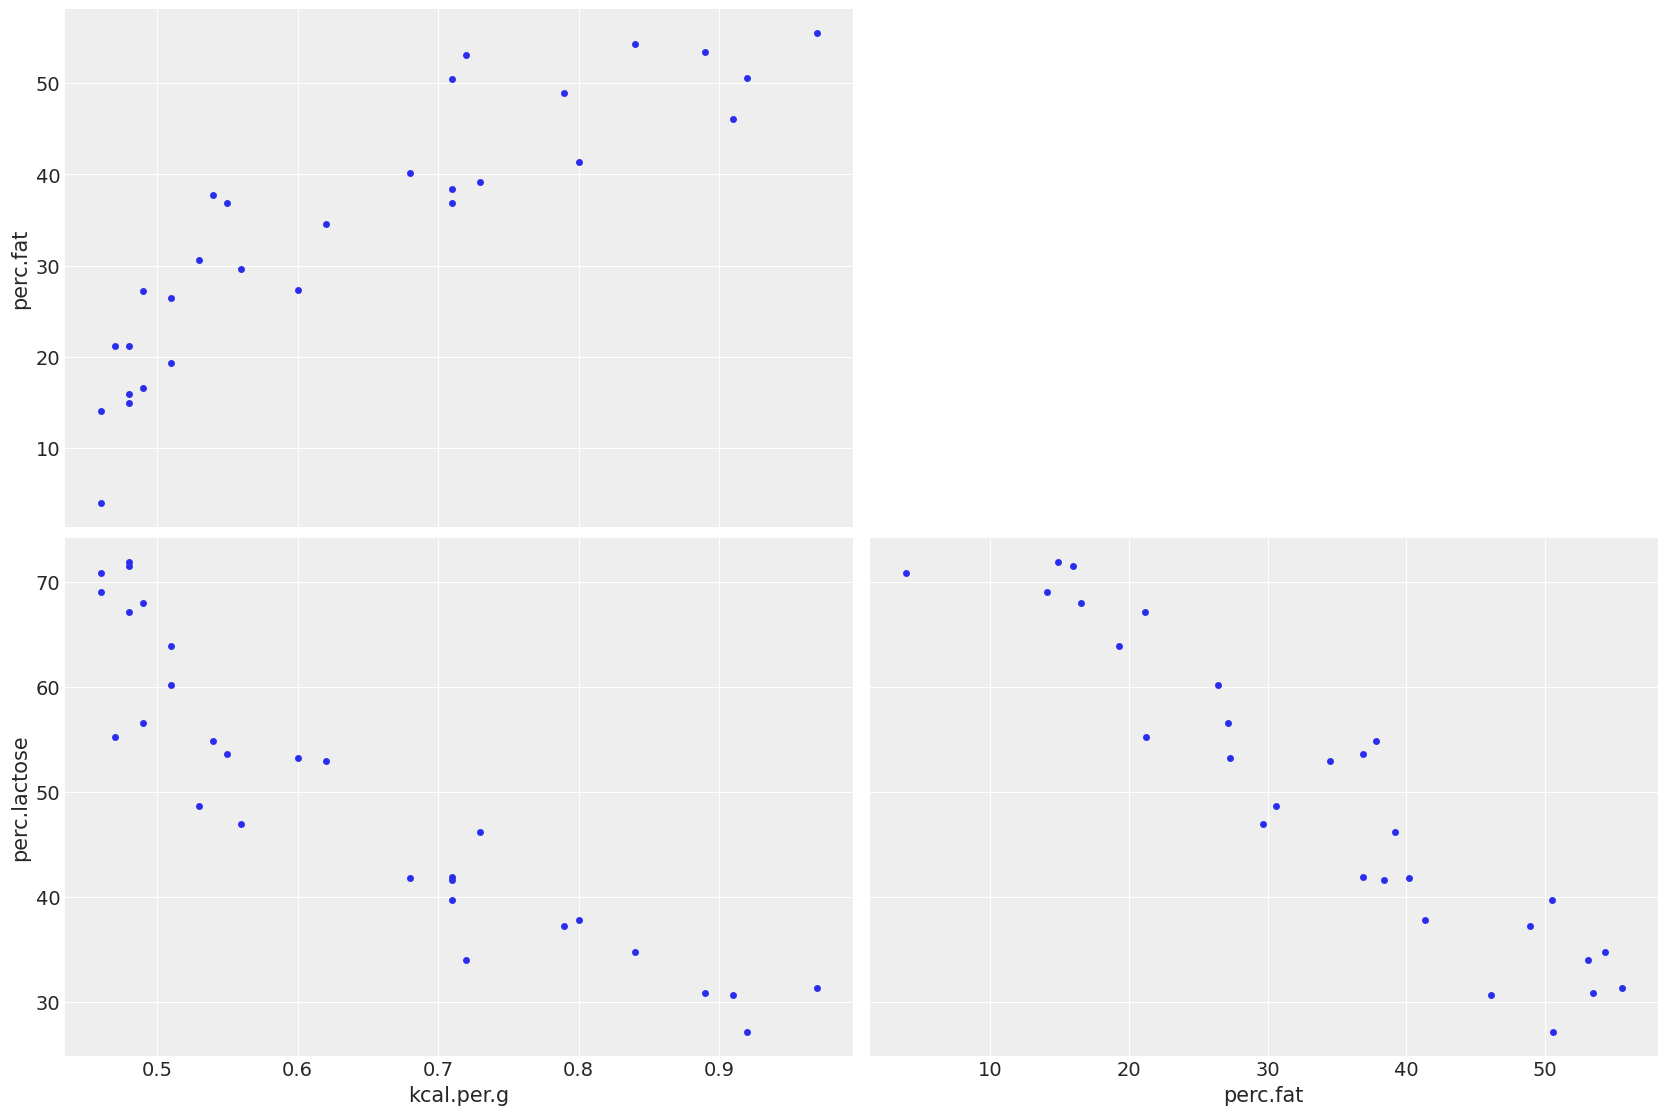

In [42]:
# 6.11
az.plot_pair(d[["kcal.per.g", "perc.fat", "perc.lactose"]].to_dict("list"), scatter_kwargs={'s': 100})
plt.show()

We again observe the positive correlation to _kcal.per.g_ for _perc.fat_ and conversely the negative correlation for _perc.lactose_. Moreover, _perc.fat_ and _perc.lactose_ are strongly negatively correlated with each other, meaning that knowing about one variable already tells us much about the other variable. Hence, _neither variable helps much once you already know the other_.

"In the scientific literature, you might encounter a variety of dodgy ways of coping with multicollinearity. Few of them take a causal perspective. Some fields actually teach students to inspect pairwise correlations before fitting a model, to identify and drop highly correlated predictors. This is a mistake. Pairwise correlations are not the problem. It is the conditional associations—not correlations—that matter. And even then, the right thing to do will depend upon what is causing the collinearity. The associations within the data alone are not enough to decide what to do."

## 6.2 Post-treatment bias